# Test Using BigQuery to Analyze DC2 Run 1.1p
Michael Wood-Vasey
Last Run: 2018-10-15

Demonstration Notebook of querying DC2 Run 1.1p Object Table as stored in Google Cloud BigQuery.

Data loading, and particularly calculations within the database are 10-20 faster than reading through flat files through NERSC or local laptop/desktop.

### Process

1. Store Parquet files in Google Cloud Storage Bucket using a test storage area (under my personal account:
    a. `dpdd_object_simple.parquet`
        -- 'simple' refers to the file_scheme.  Just one file instead of, e.g., a `Hive` format, which somewhat oddly, BigQuery doesn't offer to read.
    b. `dpdd_object_tract_4850.parquet`
        -- The per-tract files are in the 'simple' format.

These are the outputs of analyzing the DM Science Pipelines coadd+forced position photometry on images generated by PhoSim based on simulated input catalogs.

2. Load these files into BigQuery Table  using the Web BigQuery interface.

3. The data are stored in the `desc-dc2-wmwv` project

The BigQuery Table is
`desc-dc2-wmwv.run1p1p_object.run1p1p_object`

### Access
This Notebook was written as a demonstration / proof-of-concept.  Access control currenlty just limited to me (wmwv@pitt.edu) for this testing.  I'm happy to set up any individual user on request.  But I don't have any idea how to integrate with general DESC/NERSC identity management.  Will move to LSST Project Google+Project Proof-of-Concept account soon.

Authentication+Authorization Steps:
  - Created a Service Account
  - desc-dc2-owner 'Project->Owneer'
  - Store JSON file with key.
  - Store locastion of JSON file in environment variable `GOOGLE_APPLICATION_CREDENTIALS`
  - I can probably do the same for more general user/read privlidges after little more thinking.

References
* https://cloud.google.com/bigquery/docs/visualize-jupyter
* https://cloud.google.com/docs/authentication/getting-started

### Visualization
I was teaching myself Seaborn while writing this Notebook so the visualizations are in Seaborn.  We'll be doing things with dataframes so you could totally also use Holoviews+Datashader.

If you actually plot each of the ~2 million points, that will take a minute or three just to plot.  The examples I'm doing here are all binning or otherwise aggregating quantities.

In [1]:
from google.cloud import bigquery

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Load iPython magic commands from the google.cloud.bigquery library

In [3]:
%load_ext google.cloud.bigquery

Set up environment that stores locastion of credentials:

In [4]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'desc-dc2-wmwv-abebe392a10c.json'

### Calculate average g-r color:

There's not an obvious reason to do this, but it's what I was using as some simple performance testing in the `LSSTDESC/DC2-production` exploration of performance of difference data formats and access patterns.

1.8 seconds for calculating the average across 6 million records (6892380) is pretty good.  The same calculation reading from the flat files on NERSC takes 1 minute.

In [5]:
%%bigquery avg_g_r --verbose
SELECT AVG(mag_g - mag_r) FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
WHERE 
magerr_g > 0 AND magerr_g < 0.3 AND
magerr_r > 0 AND magerr_r < 0.3 AND
magerr_i > 0 AND magerr_i < 0.3

Executing query with job ID: 22551d0c-a43b-4c26-b4db-e6c04ace2c0f
Query executing: 0.96s
Query complete after 1.36s


,f0_
0,0.517273


The above is a quick way to do the query, but because it's a "magic" command it's not obvious what's happening

For programatic use, I would actually recommend explicitly using the Python library in the Client:

In [6]:
client = bigquery.Client()

In [7]:
sql = """
    SELECT ra, dec, mag_g, mag_r, mag_i, magerr_g, magerr_r, magerr_i, extendedness 
    FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
    WHERE 
    magerr_g > 0 AND magerr_g < 0.3 AND
    magerr_r > 0 AND magerr_r < 0.3 AND
    magerr_i > 0 AND magerr_i < 0.3
"""

In [8]:
df = client.query(sql).to_dataframe()

In [9]:
df['g-r'] = df['mag_g'] - df['mag_r']
df['r-i'] = df['mag_r'] - df['mag_i']

The above `client.query` command takes ~1 minute to do, which is comparable to the performance seen at NERSC on a single process.

In [10]:
len(df)

1896190

Plotting histograms is quite fast.  The data are all in memory now.

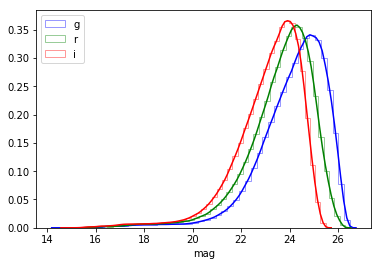

In [46]:
sns.distplot(df['mag_g'], label='g', color='blue', hist_kws={'histtype': 'step'})
sns.distplot(df['mag_r'], label='r', color='green', hist_kws={'histtype': 'step'})
sns.distplot(df['mag_i'], label='i', color='red', hist_kws={'histtype': 'step'})
plt.xlabel('mag')
plt.legend()

Now plot stars vs. galaxies.  This will be a conservative cut with a low false-positive for galaxies, but a significant false negative at lower SNR.

In [13]:
star = df[df['extendedness'] < 0.95]
gal = df[df['extendedness'] > 0.95]

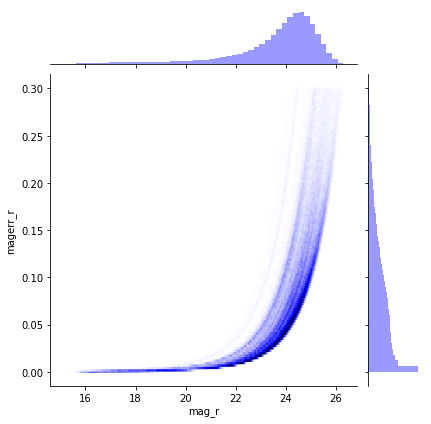

In [14]:
sns.jointplot(star['mag_g'], star['magerr_g'], label='"Stars"', color='green', kind='hexbin',
             gridsize=200)

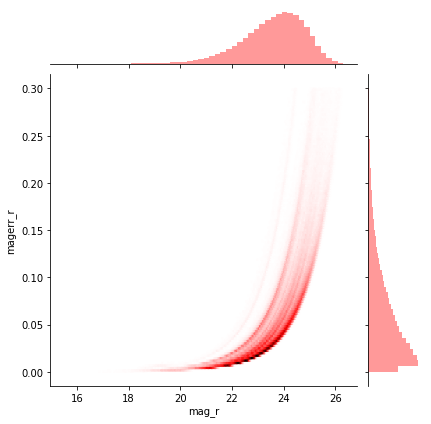

In [22]:
sns.jointplot(gal['mag_r'], gal['magerr_r'], label='Galaxies', color='red', kind='hexbin',
             gridsize=200)

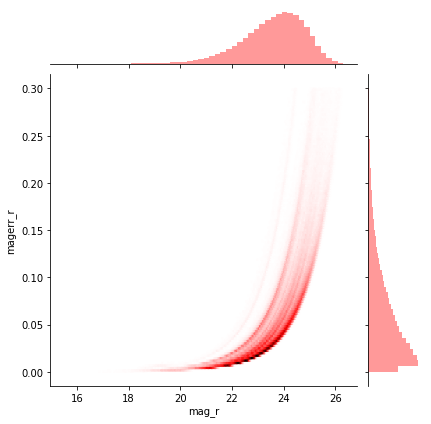

In [22]:
sns.jointplot(gal['mag_r'], gal['magerr_r'], label='Galaxies', color='red', kind='hexbin',
             gridsize=200, )

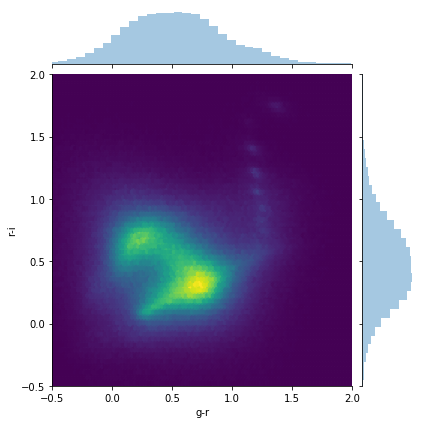

In [26]:
sns.jointplot(df['g-r'], df['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', extent=(-0.5, 2, -0.5, 2), gridsize=100, cmap='viridis',
             marginal_kws={'bins': 201})

Text(0.5, 1.0, '"Stars"')

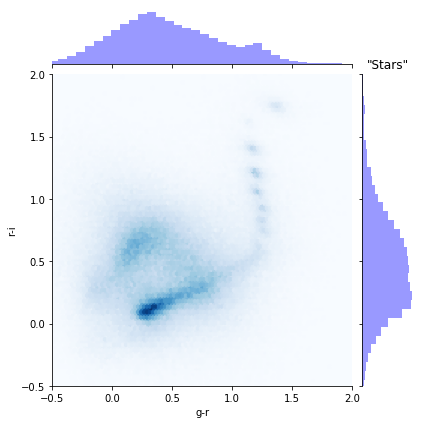

In [27]:
sns.jointplot(star['g-r'], star['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', extent=(-0.5, 2, -0.5, 2), gridsize=100, cmap='Blues',
              marginal_kws={'color': 'blue', 'bins': 201})
plt.title('"Stars"');

Note the clean stellar locus plus additional contamination from galaxies not identified as clearly extended.  The stellar locus model has a set of discrete types for M, L dwarfs.

Text(0.5, 1.0, 'Galaxies')

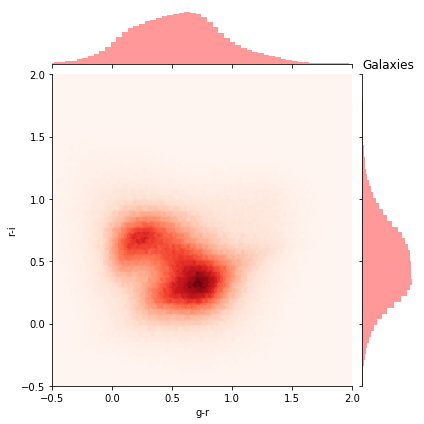

In [28]:
sns.jointplot(gal['g-r'], gal['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', gridsize=100, extent=(-0.5, 2, -0.5, 2), cmap='Reds',
              marginal_kws={'color': 'red', 'bins': 201})
plt.title('Galaxies');

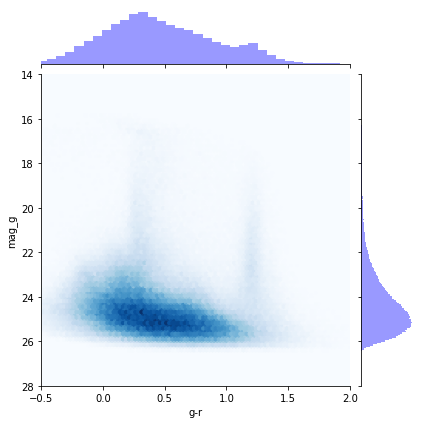

In [29]:
sns.jointplot(star['g-r'], star['mag_g'], xlim=(-0.5, 2), ylim=(28, 14),
           kind='hexbin', gridsize=100, extent=(-0.5, 2, 28, 14), cmap='Blues',
           marginal_kws={'color': 'blue', 'bins': 201},
           label='"Stars"')
plt.title('"Stars"');

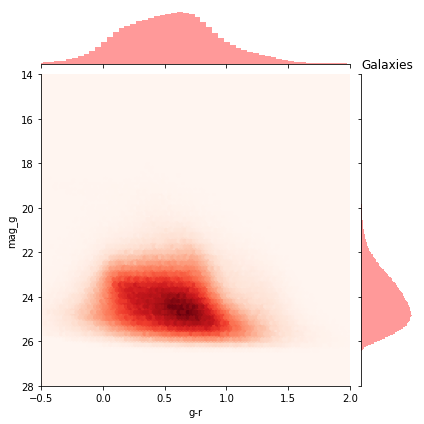

In [32]:
sns.jointplot(gal['g-r'], gal['mag_g'], xlim=(-0.5, 2), ylim=(28, 14),
           kind='hexbin', gridsize=100, extent=(-0.5, 2, 28, 14), cmap='Reds',
           marginal_kws={'color': 'red', 'bins': 201},
           label='Galaxies')
plt.title('Galaxies');

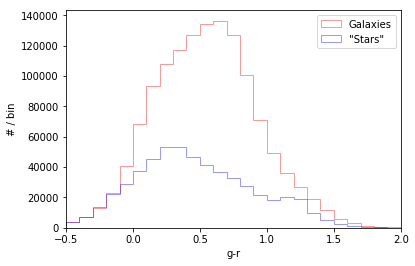

In [56]:
hist_kwargs = {'norm_hist': False, 'bins': np.linspace(-1, 2, 31), 'kde': False, 'hist_kws': {'histtype': 'step'}}

sns.distplot(gal['g-r'], label='Galaxies', color='red', **hist_kwargs)
sns.distplot(star['g-r'], label='"Stars"', color='blue',  **hist_kwargs)
plt.xlim(-0.5, 2)
plt.xlabel('g-r')
plt.ylabel('# / bin')

plt.legend();